<p style='text-align: justify;'>
<b>Ejercicio 2:</b> Utilice para entrenamiento y prueba los conjuntos de datos <i>concent_trn.csv</i> y <i>concent_tst.csv</i>, que consisten en dos clases distribuidas en forma concéntrica como muestra la Figura 1. Determine la estructura de una red de tipo perceptrón multicapa que resulte más apropiada para resolver este problema. Represente gráficamente, con diferentes colores, el resultado de la clasificación realizada por el perceptrón multicapa.</p>

#### <b>Librerías</b>

In [163]:
import random
import csv
import numpy as np
import matplotlib.pyplot as plt

#### **Paso 1:** Inicialización
Determino la estructura de mi red neuronal: el número de capas y neuronas para cada capa. En la variable *cant_entradas*, el primer elemento son las entradas x1,x2,... del archivo, mientras que los próximos elementos me determinan la cantidad de neuronas por capa. 

In [164]:
cant_entradas = np.array([2,4,1]) # Variable a cambiar según mi red neuronal

cant_capas = len(cant_entradas) - 1
cant_salidas = cant_entradas[cant_capas]

Levantamos los datos del archivo .csv, separando en un vector para las entradas y otro para las salidas esperadas. En este caso, entrenamos y probamos el algoritmo con el problema concent, para lo cual usaremos una red de dos capas y dos entradas x_i. La capa de entrada tendrá 4 neuronas y la capa de salida tendrá 1 neurona. 

La arquitectura mínima para poder resolver este problema es 3-1 ya que necesito hacer una región de decisión cerrada. Con solo 2 neuronas en la capa de entrada probablemente no se cierre la región que genera, aunque podría quedar como un ojo dependiendo del parámetro de la función sigmoidea.

In [165]:
trn = np.loadtxt('./data/concent_trn.csv',delimiter=',')

inputs = np.empty(len(trn),dtype=object)      # Vector de entradas
yd = np.empty(len(trn),dtype=object)          # Salida esperadas
for i in range(len(trn)):
    fila = trn[i]
    cant_e = cant_entradas[0]   # Cantidad de entradas
    yd[i] = fila[cant_e:]
    aux = [-1]                  # Añado entrada -1 correspondiente al umbral/sesgo
    for j in range(cant_e):
        aux.append(fila[j])
    inputs[i] = aux                # Vector de entradas por patrón

Inicializo al azar las matrices de pesos de cada capa.

In [166]:
# Inicializo la matriz de pesos para cada una de las capas.
w = []
for i in range(len(cant_entradas)-1):
    w_aux = np.random.rand(cant_entradas[i+1],cant_entradas[i]+1)-0.5
    w.append(w_aux)     # Añado al vector de matrices de pesos

# Estructura de la matriz:
print(w)
# El elemento w_ij = w[i][j] de la matriz me da los pesos correspondientes a la neurona j de la capa i. 
# El elemento w_ij[k] me da el peso asociado a la entrada k de la neurona j de la capa i.

y = np.empty(cant_capas,dtype=object)
delta = np.empty(cant_capas,dtype=object)

[array([[ 0.49791913, -0.2279149 , -0.20580706],
       [ 0.18940166, -0.43895698,  0.42234883],
       [-0.38781167,  0.16428296, -0.46815364],
       [ 0.43650483, -0.14007148, -0.22706274]]), array([[-0.07324382,  0.46119894, -0.35167782, -0.36569239, -0.46237826]])]


#### **Paso 2:** Entrenamiento
Continuando con el algoritmo, realizamos los pasos de propagación hacia adelante, propagación hacia atrás y adaptación de los pesos en distintas épocas para todas las capas de nuestra red neuronal. Realizamos una pasada de aprendizaje y otra de validación para evaluar el desempeño del mismo.

Defino funciones auxiliares para la sigmoidea y su derivada a modo de simplificar el código:

In [167]:
def sigmoidea(v):
    return ((2/(1+np.exp(-v)))-1)

def d_sigmoidea(y):
    return ((1+y)*(1-y))

In [168]:
# DATOS PARA EL ALGORITMO:
epoca = 1               # Contador para época actual
epoca_max = 2000        # Máximo de iteraciones
mu = 0.01               # Velocidad de aprendizaje
perc_error_max = 0.01   # Porcentaje máximo de error
errores_por_epoca = []
mse_por_epoca = []

while (epoca < epoca_max):  
    
    #--------------------------------#
    #--------- Aprendizaje ----------#
    #--------------------------------#

    for patron in range(len(trn)):

        # PROPAGACIÓN HACIA ADELANTE: Obtengo la salida de las capas y las propago como entradas de las próximas
        entradas = inputs[patron]          # La primera capa tiene las entradas en el archivo .csv
        for i in range(cant_capas):
            v = w[i]@entradas                  # Producto interno de pesos y entradas
            y[i] = sigmoidea(v)        # Salida con función de activación
            entradas = np.hstack((-1,y[i]))    # Entrada de la próxima capa es la salida de esta capa

        # PROPAGACIÓN HACIA ATRÁS: Obtengo el delta de la capa de salida y lo propago a las capas anteriores
        error = yd[patron] - y[-1]                    
        delta[-1]=error*(1/2)*d_sigmoidea(y[-1])       # Con el error, obtengo el delta de la capa de salida
        for i in range(cant_capas-1,0,-1):
            w_i = w[i][:,1:].T                          # No tomo el peso w0 (umbral) porque no tiene delta para propagar
            d = np.dot(w_i,delta[i])
            delta[i-1] = d*(1/2)*d_sigmoidea(y[i-1])  # Con los pesos de la capa i obtenemos el delta de la capa i-1

        # ACTUALIZAR LOS PESOS: Ajusto los pesos con la velocidad de aprendizaje, la entrada y su delta.
        entradas = inputs[patron]          # La primera capa tiene las entradas en el archivo .csv
        for i in range(cant_capas):
            delta_peso = mu*(np.outer(delta[i],entradas))
            w[i] += delta_peso
            entradas = np.hstack((-1,y[i]))    # Entrada para próxima capa es la salida de esta
    
    #--------------------------------#
    #---------- Evaluación ----------#
    #--------------------------------#
    cont_errores = 0    # Contador de errores
    cont_mse = 0        # Contador para error cuadrático medio

    for patron in range(len(trn)): 

        # PROPAGACIÓN HACIA ADELANTE: Obtengo la salida de las capas y las propago como entradas de las próximas
        entradas = inputs[patron]          # La primera capa tiene las entradas en el archivo .csv
        for i in range(cant_capas):
            v = w[i]@entradas                   # Producto interno de pesos y entradas
            y[i] = sigmoidea(v)               # Salida con función de activación
            entradas = np.hstack((-1,y[i]))     # Entrada de la próxima capa es la salida de esta capa
        
        # CODIFICACIÓN: Función signo
        if (y[-1] < 0): yc = -1
        else: yc = 1

        # Actualizo contadores de error:
        if(yd[patron] != yc): cont_errores += 1
        cont_mse += np.sum(np.square(yd[patron]-y[-1])) 
    
    # Actualizo arrays para grafica de error:
    mse = cont_mse/len(trn)
    mse_por_epoca.append(mse)
    perc_error = cont_errores/len(trn)
    errores_por_epoca.append(perc_error)

    if(perc_error < perc_error_max): break

    epoca += 1

acierto = (1-cont_errores/len(trn))*100
print('Finalizó el entrenamiento en la época ',epoca,' con ',cont_errores,'/',len(trn),' errores. Tasa de acierto: ',round(acierto,2),'%')

Finalizó el entrenamiento en la época  1025  con  14 / 1499  errores. Tasa de acierto:  99.07 %


#### **Paso 3:** Prueba
Una vez obtenidos los pesos mediante el entrenamiento, pasamos otro dataset por la red neuronal para probarla. Comenzamos levantando el archivo .csv de la misma forma que para el entrenamiento.

In [169]:
tst = np.loadtxt('./data/concent_tst.csv',delimiter=',')

inputs = np.empty(len(tst),dtype=object)      # Vector de entradas
yd = np.empty(len(tst),dtype=object)          # Salida esperadas
for i in range(len(tst)):
    fila = tst[i]
    cant_e = cant_entradas[0]   # Cantidad de entradas
    yd[i] = fila[cant_e:]    
    aux = [-1]                  # Añado entrada -1 correspondiente al umbral/sesgo
    for j in range(cant_e):
        aux.append(fila[j])
    inputs[i] = aux                # Vector de entradas por patrón

Realizamos la propagación hacia adelante, manteniendo un contador de errores para determinar la eficiencia del entrenamiento.

In [170]:
y = np.empty(cant_capas,dtype=object)   # Vector de salidas
cont_errores = 0                        # Contador de errores
y_saved = []

for patron in range(len(tst)): 
    entradas = inputs[patron]
    for i in range(cant_capas):
        v = w[i]@entradas                   # Producto interno de pesos y entradas
        y[i] = sigmoidea(v)       # Salida con función de activación
        entradas = np.hstack((-1,y[i]))     # La entrada de la próxima capa es la salida de la actual.
    
    yc = np.sign(y[-1])
    y_saved.append(yc)
    if((yd[patron] != yc).any()): cont_errores += 1

acierto = (1-cont_errores/len(tst))*100
print('Finalizó la prueba con ',cont_errores,'/',len(tst),' errores. Tasa de acierto: ',round(acierto,2),'%')

Finalizó la prueba con  14 / 1000  errores. Tasa de acierto:  98.6 %


#### **Paso 4:** Grafica
Realizamos una gráfica para cada capa. La capa de entrada tendrá graficados los puntos de las entradas del archivo, mientras que las capas subsiguientes graficarán los puntos dados por su capa previa.

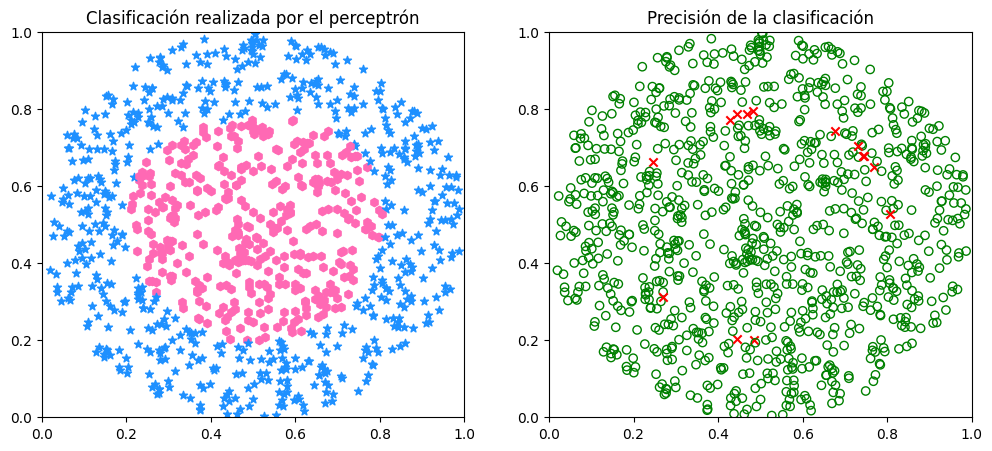

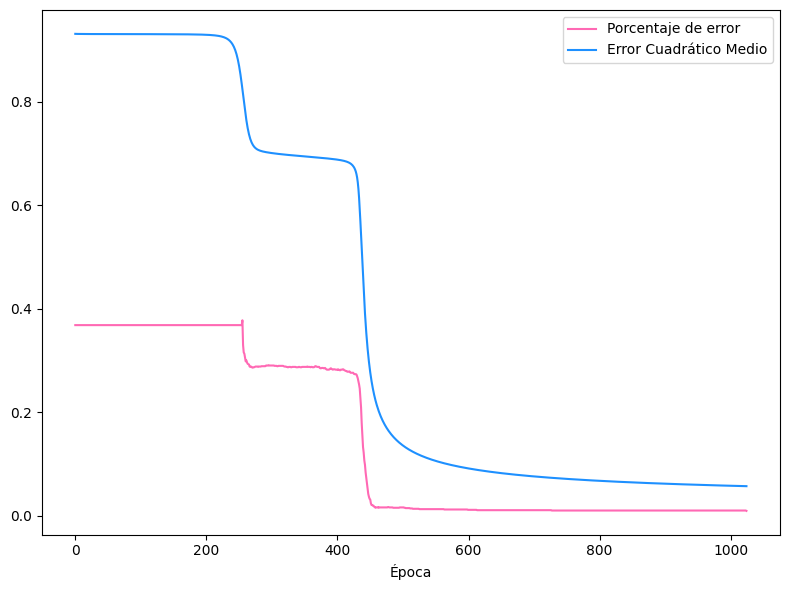

In [171]:
fig,ax = plt.subplots(1,2,figsize=(12,5))

# GRÁFICAS DE RECTA DE SEPARACIÓN
ax[0].set(xlim=[0,1],ylim=[0,1],title='Clasificación realizada por el perceptrón')
ax[1].set(xlim=[0,1],ylim=[0,1],title='Precisión de la clasificación')
xx = np.linspace(-0.5, 1.5, 100)

# PUNTOS:
for i in range(len(y_saved)):
    if y_saved[i] == -1: # Según resultado esperado de la entrada:
        ax[0].scatter(tst[i,0], tst[i,1], color='hotpink', marker='h') 
    else:
        ax[0].scatter(tst[i,0], tst[i,1], color='dodgerblue', marker='*') 
    if y_saved[i] != yd[i]:
        ax[1].scatter(tst[i,0], tst[i,1], color='red', marker = 'x')
    else:
        ax[1].scatter(tst[i,0], tst[i,1], color='none',edgecolor='green',marker = 'o')

# GRÁFICAS DE ERROR
fig,ax = plt.subplots(figsize=(8,6))
x = range(len(errores_por_epoca))

ax.plot(x, errores_por_epoca, label='Porcentaje de error',color='hotpink')
ax.plot(x, mse_por_epoca, label='Error Cuadrático Medio',color='dodgerblue')
ax.set_xlabel('Época')
ax.legend()
plt.tight_layout()
plt.show()